In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-afdadd|\\\\\ZX\C\donly "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
                                            
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [14]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, 1:].values
        self.X = self.X.reshape(-1,1, 28, 28).astype(np.float32)/255
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


In [15]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1, 28, 28)
        return x
        

In [18]:
def model_training(model, criterion, optimizer, epochs=50):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_loss = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            
        avg_train_loss = total_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()    
        total_test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                total_test_loss += loss.item()


        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")

                
    return train_losses, test_losses
    


In [19]:
def visualize_reconstruction(model, num_images=10):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images.to(device)
        outputs = model(images)
        
        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, num_images, figsize=(num_images*2, 4))
        for i in range(num_images):
            axes[0, i].imshow(images[i][0], cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(outputs[i][0], cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('Original', fontsize=14)
        axes[1, 0].set_ylabel('Reconstructed', fontsize=14)
        plt.show()

In [20]:
def loss_curve(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs for Bottleneck Auto-Encoder(VAE)")
    plt.legend()
    plt.show()


Training Autoencoder with Latent Dim = 100
Epoch 1/20 | Train Loss: 3543.7995 | Test Loss: 2492.7234
Epoch 2/20 | Train Loss: 2320.2554 | Test Loss: 2214.1100
Epoch 3/20 | Train Loss: 2125.6369 | Test Loss: 2089.1200
Epoch 4/20 | Train Loss: 2032.5772 | Test Loss: 2014.1392
Epoch 5/20 | Train Loss: 1977.3325 | Test Loss: 1988.6007
Epoch 6/20 | Train Loss: 1939.3204 | Test Loss: 1942.7700
Epoch 7/20 | Train Loss: 1912.1569 | Test Loss: 1938.8667
Epoch 8/20 | Train Loss: 1890.5112 | Test Loss: 1905.8161
Epoch 9/20 | Train Loss: 1872.7832 | Test Loss: 1893.9023
Epoch 10/20 | Train Loss: 1857.7729 | Test Loss: 1887.4458
Epoch 11/20 | Train Loss: 1846.6218 | Test Loss: 1876.7173
Epoch 12/20 | Train Loss: 1836.0525 | Test Loss: 1868.4664
Epoch 13/20 | Train Loss: 1825.8831 | Test Loss: 1856.5295
Epoch 14/20 | Train Loss: 1819.4741 | Test Loss: 1851.6975
Epoch 15/20 | Train Loss: 1811.6134 | Test Loss: 1853.8397
Epoch 16/20 | Train Loss: 1804.7153 | Test Loss: 1842.2897
Epoch 17/20 | Train L

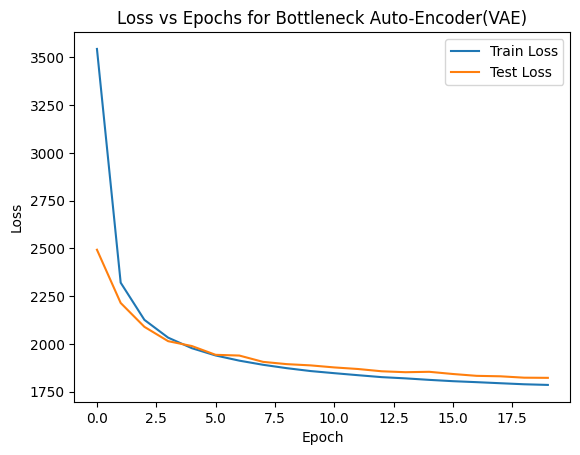

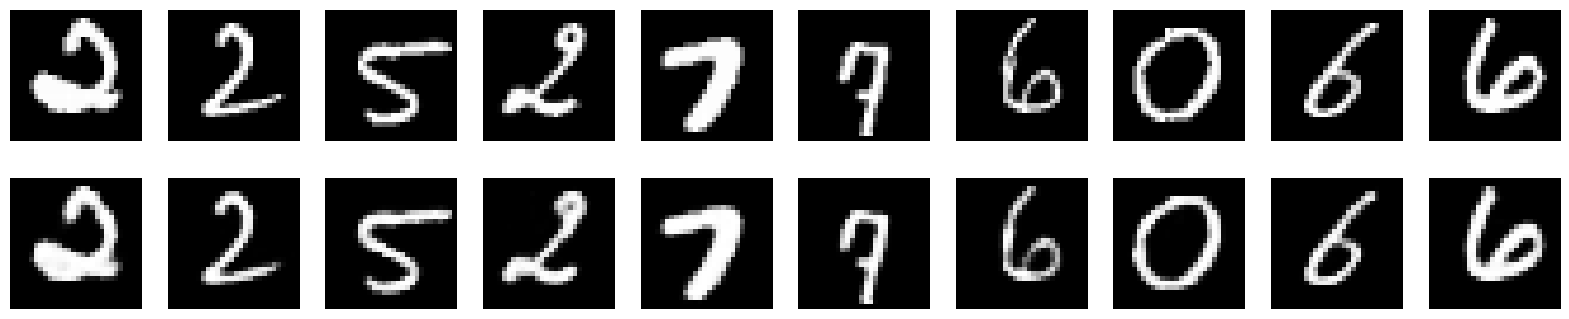


Training Autoencoder with Latent Dim = 50
Epoch 1/20 | Train Loss: 3527.6068 | Test Loss: 2492.1627
Epoch 2/20 | Train Loss: 2345.4592 | Test Loss: 2231.5650
Epoch 3/20 | Train Loss: 2159.9245 | Test Loss: 2116.6810
Epoch 4/20 | Train Loss: 2072.1831 | Test Loss: 2050.3661
Epoch 5/20 | Train Loss: 2018.4761 | Test Loss: 2023.1400
Epoch 6/20 | Train Loss: 1982.7444 | Test Loss: 1995.5024
Epoch 7/20 | Train Loss: 1957.5215 | Test Loss: 1974.5765
Epoch 8/20 | Train Loss: 1937.0102 | Test Loss: 1967.9662
Epoch 9/20 | Train Loss: 1922.0331 | Test Loss: 1955.9386
Epoch 10/20 | Train Loss: 1909.9393 | Test Loss: 1942.4160
Epoch 11/20 | Train Loss: 1898.9369 | Test Loss: 1929.5625
Epoch 12/20 | Train Loss: 1889.6572 | Test Loss: 1932.6328
Epoch 13/20 | Train Loss: 1882.7271 | Test Loss: 1921.7963
Epoch 14/20 | Train Loss: 1877.3375 | Test Loss: 1920.9623
Epoch 15/20 | Train Loss: 1871.7447 | Test Loss: 1915.5465
Epoch 16/20 | Train Loss: 1866.4901 | Test Loss: 1910.3964
Epoch 17/20 | Train Lo

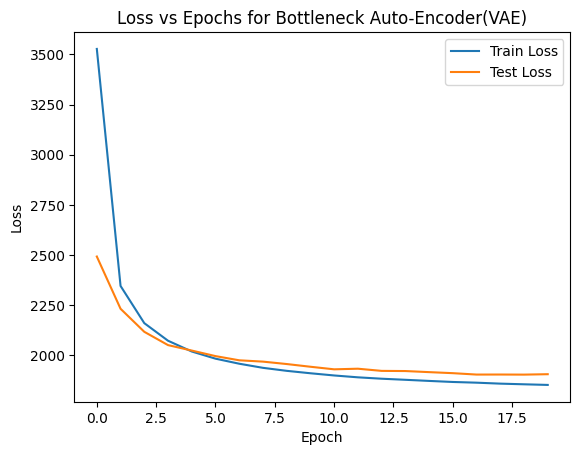

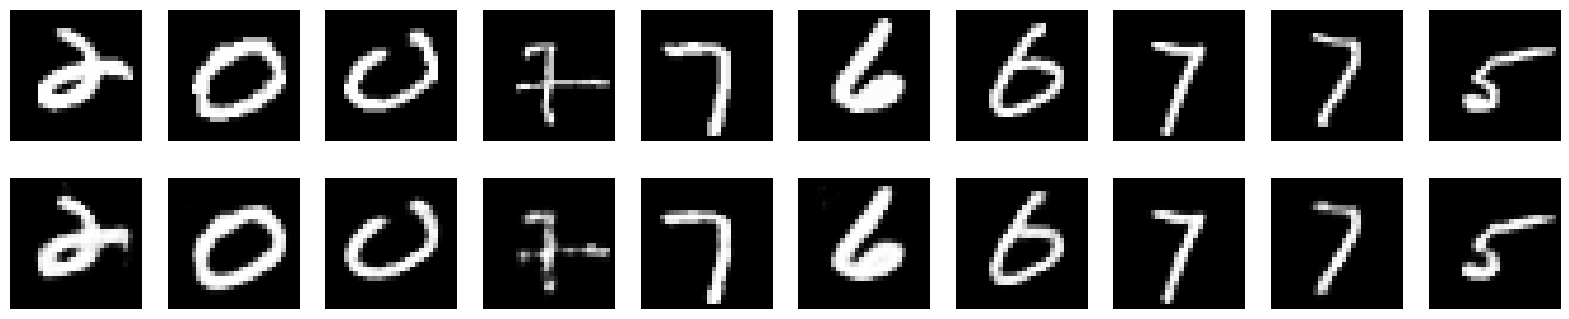


Training Autoencoder with Latent Dim = 30
Epoch 1/20 | Train Loss: 3573.1710 | Test Loss: 2544.2681
Epoch 2/20 | Train Loss: 2407.4477 | Test Loss: 2291.3710
Epoch 3/20 | Train Loss: 2241.2921 | Test Loss: 2202.0229
Epoch 4/20 | Train Loss: 2167.5386 | Test Loss: 2156.4354
Epoch 5/20 | Train Loss: 2123.5892 | Test Loss: 2132.2949
Epoch 6/20 | Train Loss: 2094.2841 | Test Loss: 2109.8893
Epoch 7/20 | Train Loss: 2071.5659 | Test Loss: 2093.7224
Epoch 8/20 | Train Loss: 2055.3173 | Test Loss: 2076.6861
Epoch 9/20 | Train Loss: 2040.8609 | Test Loss: 2076.1261
Epoch 10/20 | Train Loss: 2029.4955 | Test Loss: 2066.2519
Epoch 11/20 | Train Loss: 2020.1356 | Test Loss: 2058.7009
Epoch 12/20 | Train Loss: 2011.8231 | Test Loss: 2063.0464
Epoch 13/20 | Train Loss: 2004.8558 | Test Loss: 2055.0978
Epoch 14/20 | Train Loss: 1998.8744 | Test Loss: 2047.3026
Epoch 15/20 | Train Loss: 1992.7160 | Test Loss: 2043.5395
Epoch 16/20 | Train Loss: 1988.3206 | Test Loss: 2038.7836
Epoch 17/20 | Train Lo

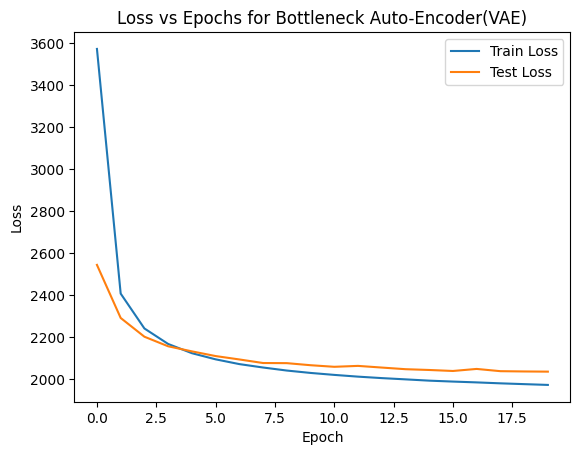

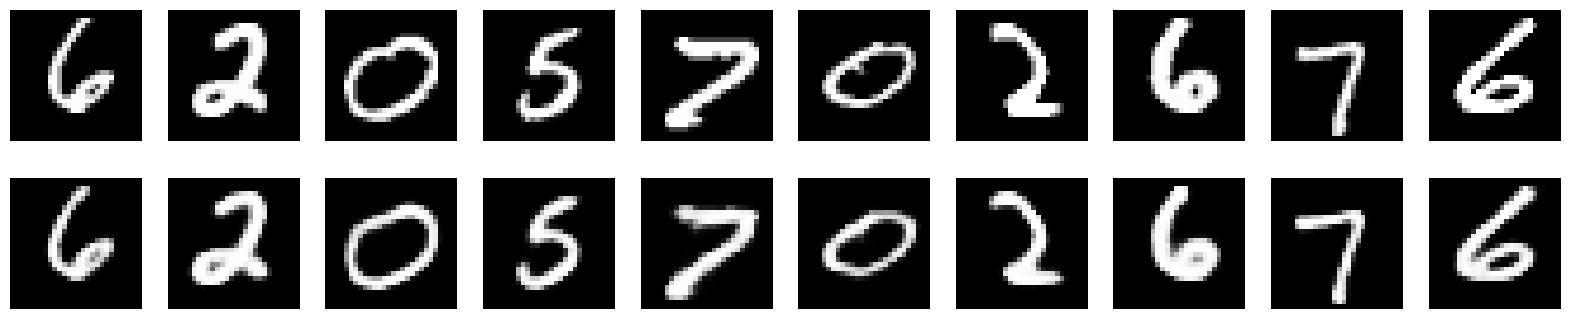


Training Autoencoder with Latent Dim = 20
Epoch 1/20 | Train Loss: 3669.1449 | Test Loss: 2697.3067
Epoch 2/20 | Train Loss: 2580.8359 | Test Loss: 2495.1063
Epoch 3/20 | Train Loss: 2437.4043 | Test Loss: 2400.2940
Epoch 4/20 | Train Loss: 2364.2290 | Test Loss: 2356.7322
Epoch 5/20 | Train Loss: 2317.8608 | Test Loss: 2326.0608
Epoch 6/20 | Train Loss: 2285.0456 | Test Loss: 2318.3067
Epoch 7/20 | Train Loss: 2260.9344 | Test Loss: 2290.2367
Epoch 8/20 | Train Loss: 2240.1182 | Test Loss: 2272.8180
Epoch 9/20 | Train Loss: 2224.1398 | Test Loss: 2262.1145
Epoch 10/20 | Train Loss: 2210.1956 | Test Loss: 2252.0046
Epoch 11/20 | Train Loss: 2199.3260 | Test Loss: 2245.9490
Epoch 12/20 | Train Loss: 2188.7472 | Test Loss: 2237.0079
Epoch 13/20 | Train Loss: 2179.9034 | Test Loss: 2234.0757
Epoch 14/20 | Train Loss: 2171.2661 | Test Loss: 2238.1985
Epoch 15/20 | Train Loss: 2164.7625 | Test Loss: 2234.4683
Epoch 16/20 | Train Loss: 2159.0511 | Test Loss: 2227.2848
Epoch 17/20 | Train Lo

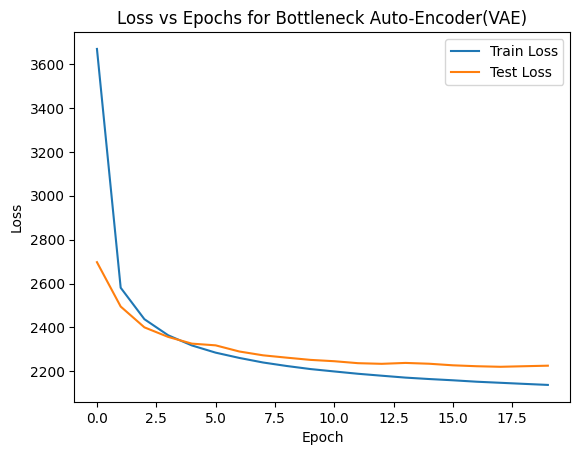

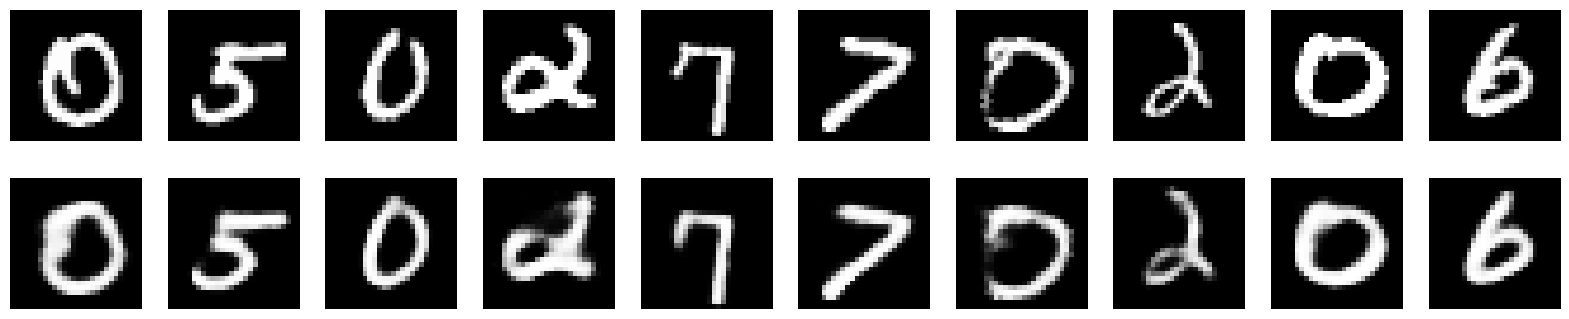

In [24]:
latent_dims = [100, 50, 30, 20]
criterion = nn.BCELoss(reduction='sum')

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with Latent Dim = {latent_dim}")
    model = AutoEncoder(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    train_losses, test_losses = model_training(model, criterion, optimizer, epochs=20)
    loss_curve(train_losses, test_losses)
    # Visualize reconstruction
    visualize_reconstruction(model)
